In [24]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Random
using Distributions
using FFTW
# using Pkg
# Pkg.add("AbstractGPs")
# Pkg.add("LogExpFunctions")
using AbstractGPs, LogExpFunctions, Turing


In [25]:
function meshgrid(x,y)
    n = length(y)
    m = length(x)
    X = Matrix{eltype(x)}(undef, n, m)
    Y = Matrix{eltype(y)}(undef, n, m)
    @views @simd for i in eachindex(y)
        X[i,:] = x
    end
    @views @simd for j in eachindex(x)
        Y[:,j] = y
    end
    return X, Y
end
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end

Autocorrelation (generic function with 1 method)

(150,)
(150,)


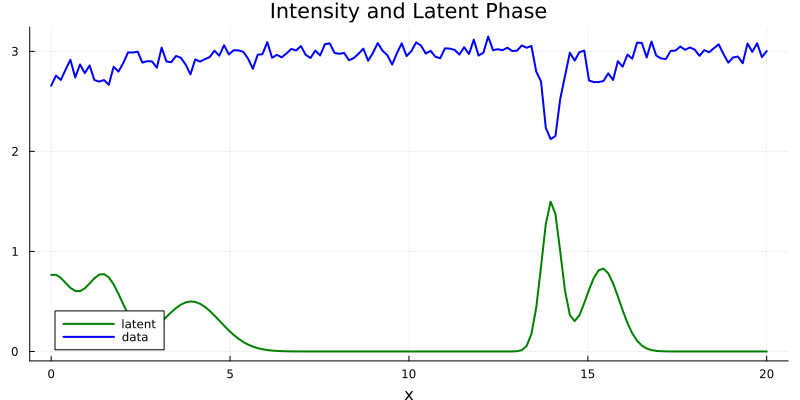

In [26]:
gaussian(x, σ) = @. exp(-x^2 / (2σ^2)) / (σ * sqrt(2π))
Random.seed!(1)
n = 150
N_electrons = 10_00
L = 20
ϵ = 0.01
y_latent = zeros(n)
x_train = collect(LinRange(0.0, L, n))
for i in 1:5
    x0 = rand(Uniform(0, L))
    σ = rand(truncated(Normal(0, 1), 0.1, 1))
    y_latent += gaussian(x_train.-x0, σ) #.+ ϵ * randn(n)
end
# y_latent += ϵ * randn(n)
println(size(y_latent))
println(size(x_train))



Intensity = 2 .+ cos.(y_latent)
y_train = rand.(Poisson.(Intensity*N_electrons))

plot(x_train, y_latent, 
    label = "latent", 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "",
    markersize = 2, size = (800, 400), color = :green, linewidth = 2)
plot!(x_train, y_train./N_electrons, 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)

In [27]:
I_auto = Autocorrelation(y_train)
I_auto = I_auto ./ maximum(I_auto)
I_auto = I
plot(x_train, I_auto, 
    label = "autocorrelation", 
    title = "Autocorrelation of the data", 
    xlabel = "x", ylabel = "",
    markersize = 2, size = (800, 400), color = :red, linewidth = 2)
# plot!(x_train, y_latent,
#     label = "latent", 
#     markersize = 2, 
#     color = :green, linewidth = 2)

ErrorException: Cannot convert UniformScaling{Bool} to series data for plotting

In [4]:
using ReverseDiff
using Turing
using Distributions
using BSplines
# using Pkg
# Pkg.add("BSplines")
# using AdTypes

@model function latent_model(y, x_input=x_train, n_points=n, N_poisson=N_electrons)
    v ~ Gamma(2, 1)
    l ~ Gamma(4, 1)
    jitter ~ Uniform(0, 0.04)
    
    f = GP(v * with_lengthscale(SEKernel(), l))
    # f_latent ~ truncated(f(x_input, jitter), -0.2, π/2 + 0.2)
    f_latent ~ f(x_input, jitter)
    local I = (2 .+ cos.(f_latent)).* N_electrons


    y ~ arraydist(Poisson.(I))
end

model = latent_model(y_train)
sampler = Turing.NUTS(10,0.65, max_depth=6; adtype=AutoReverseDiff(compile=true))

chain = sample(model, sampler, 2000; progress=true)

InterruptException: InterruptException:

In [121]:

using Pigeons


using ReverseDiff
using Turing
using Distributions
using BSplines
# using Pkg
# Pkg.add("Zygote")
# using Zygote
# using Turing: AutoZygote
using ADTypes

@model function latent_model(y, x_input=x_train, N_poisson=N_electrons)
    λ ~ Uniform(0, 10)
    # γ ~ Uniform(0, 100)
    # scale ~ Uniform(0, 1000)
    γ = 100
    scale = 1e3
    weights ~ filldist(Uniform(-2, 10), length(basis))
    # scale = 10
    spline = Spline(basis, weights)
    I = @. (2 + spline(x_input))* N_poisson
    # L = @. logistic((spline(x_input) + 1)*scale)*logistic((1 - spline(x_input))*scale)
    L = @. log(logistic((spline(x_input) + 1)*scale)+eps()) + 
        log(logistic((1 - spline(x_input))*scale) + eps())

    # if any(x -> x >= 1, spline.(x_input))
    #     return -Inf
    # end
    # Turing.@addlogprob! -2γ*sqrt(λ)*sum((diff(weights)).^2)
    Turing.@addlogprob! -λ*sum((diff(diff(weights))).^2)
    # Turing.@addlogprob! γ*sum(L)
    Turing.@addlogprob! sum(L)
    y ~ arraydist(Poisson.(I))
end
my_turing_target = TuringLogPotential(latent_model(y_train))
# sampler = Turing.NUTS(10,0.65, max_depth=6; adtype=AutoReverseDiff(compile=true))
n_chains = 3
n_rounds = 7
# my_turing_model = TuringLogPotential(infinite_chain(noised_reshaped))
inputs = Inputs(target = my_turing_target,
            n_chains = n_chains,
            n_rounds = n_rounds,
            multithreaded = true,
            explorer = AutoMALA(default_autodiff_backend = AutoReverseDiff(compile=true)),
            record = [traces])

pt = pigeons(inputs)

chain = Chains(pt);
# sampler = Turing.NUTS(10,0.65, max_depth=6; adtype=AutoZygote())

# chain = sample(model, sampler, 2000; progress=true)

Chains MCMC chain (128×79×1 Array{Float64, 3}):

Iterations        = 1:1:128
Number of chains  = 1
Samples per chain = 128
parameters        = λ, weights[1], weights[2], weights[3], weights[4], weights[5], weights[6], weights[7], weights[8], weights[9], weights[10], weights[11], weights[12], weights[13], weights[14], weights[15], weights[16], weights[17], weights[18], weights[19], weights[20], weights[21], weights[22], weights[23], weights[24], weights[25], weights[26], weights[27], weights[28], weights[29], weights[30], weights[31], weights[32], weights[33], weights[34], weights[35], weights[36], weights[37], weights[38], weights[39], weights[40], weights[41], weights[42], weights[43], weights[44], weights[45], weights[46], weights[47], weights[48], weights[49], weights[50], weights[51], weights[52], weights[53], weights[54], weights[55], weights[56], weights[57], weights[58], weights[59], weights[60], weights[61], weights[62], weights[63], weights[64], weights[65], weights[66], weigh

In [61]:
using BSplines
using Pkg
# Pkg.add("StatsFuns")
using StatsFuns: logistic
order = 3  # Cubic B-splines
N_knots = length(x_train[1:2:end])
knots_list = x_train[1:2:end]
basis = BSplineBasis(order, knots_list)

76-element BSplineBasis{Vector{Float64}}:
 order: 3
 breakpoints: [0.0, 0.268456, 0.536913, 0.805369, 1.07383, 1.34228, 1.61074, 1.87919, 2.14765, 2.41611  …  17.4497, 17.7181, 17.9866, 18.255, 18.5235, 18.7919, 19.0604, 19.3289, 19.5973, 19.8658]

In [97]:
using ReverseDiff
using Turing
using Distributions
using BSplines
# using Pkg
# Pkg.add("Zygote")
# using Zygote
# using Turing: AutoZygote
using ADTypes

@model function latent_model(y, x_input=x_train, N_poisson=N_electrons)
    # λ ~ Uniform(0, 10)
    λ = 0
    # γ ~ Uniform(0, 100)
    # scale ~ Uniform(0, 1000)
    γ = 100
    scale = 1e3
    weights ~ filldist(Uniform(-0.3, π), length(basis))
    # scale = 10
    spline = Spline(basis, weights)
    I = @. (2 + cos(spline(x_input)))* N_poisson
    # L = @. logistic((spline(x_input) + 1)*scale)*logistic((1 - spline(x_input))*scale)
    # L = @. log(logistic((spline(x_input) + 1)*scale)+eps()) + 
    #     log(logistic((1 - spline(x_input))*scale) + eps())

    # if any(x -> x >= 1, spline.(x_input))
    #     return -Inf
    # end
    # Turing.@addlogprob! 2hyg2γ*sqrt(λ)*sum((diff(weights)).^2)
    Turing.@addlogprob! -λ*sum((diff(diff(weights))).^2)
    # Turing.@addlogprob! γ*sum(L)
    # Turing.@addlogprob! sum(L)
    y ~ arraydist(Poisson.(I))
end

model = latent_model(y_train)
# sampler = Turing.NUTS(10,0.65, max_depth=6; adtype=AutoReverseDiff(compile=true))
sampler = Turing.NUTS(max_depth=6; adtype=AutoReverseDiff(true))
# sampler = Turing.NUTS(10,0.65, max_depth=6; adtype=AutoZygote())

chain = sample(model, sampler, 2000; progress=true)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/nicolas/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:02:31
Sampling   1%|▍                                         |  ETA: 0:01:25
Sampling   2%|▋                                         |  ETA: 0:01:03
Sampling   2%|▉                                         |  ETA: 0:00:51
Sampling   2%|█                                         |  ETA: 0:00:44
Sampling   3%|█▎                                        |  ETA: 0:00:41
Sampling   4%|█▌                                        |  ETA: 0:00:37
Sampling   4%|█▋                                        |  ETA: 0:00:35
Sampling   4%|█▉                                        |  ETA: 0:00:33
Sampling   5%|██▏                                       |  ETA: 0:00:32
Sampling   6%|██▎                                       |  ETA: 0:00:30
Sampling   6

Chains MCMC chain (2000×88×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 16.24 seconds
Compute duration  = 16.24 seconds
parameters        = weights[1], weights[2], weights[3], weights[4], weights[5], weights[6], weights[7], weights[8], weights[9], weights[10], weights[11], weights[12], weights[13], weights[14], weights[15], weights[16], weights[17], weights[18], weights[19], weights[20], weights[21], weights[22], weights[23], weights[24], weights[25], weights[26], weights[27], weights[28], weights[29], weights[30], weights[31], weights[32], weights[33], weights[34], weights[35], weights[36], weights[37], weights[38], weights[39], weights[40], weights[41], weights[42], weights[43], weights[44], weights[45], weights[46], weights[47], weights[48], weights[49], weights[50], weights[51], weights[52], weights[53], weights[54], weights[55], weights[56], weights[57], weights[58], weights[59], weights[60], weights[61],

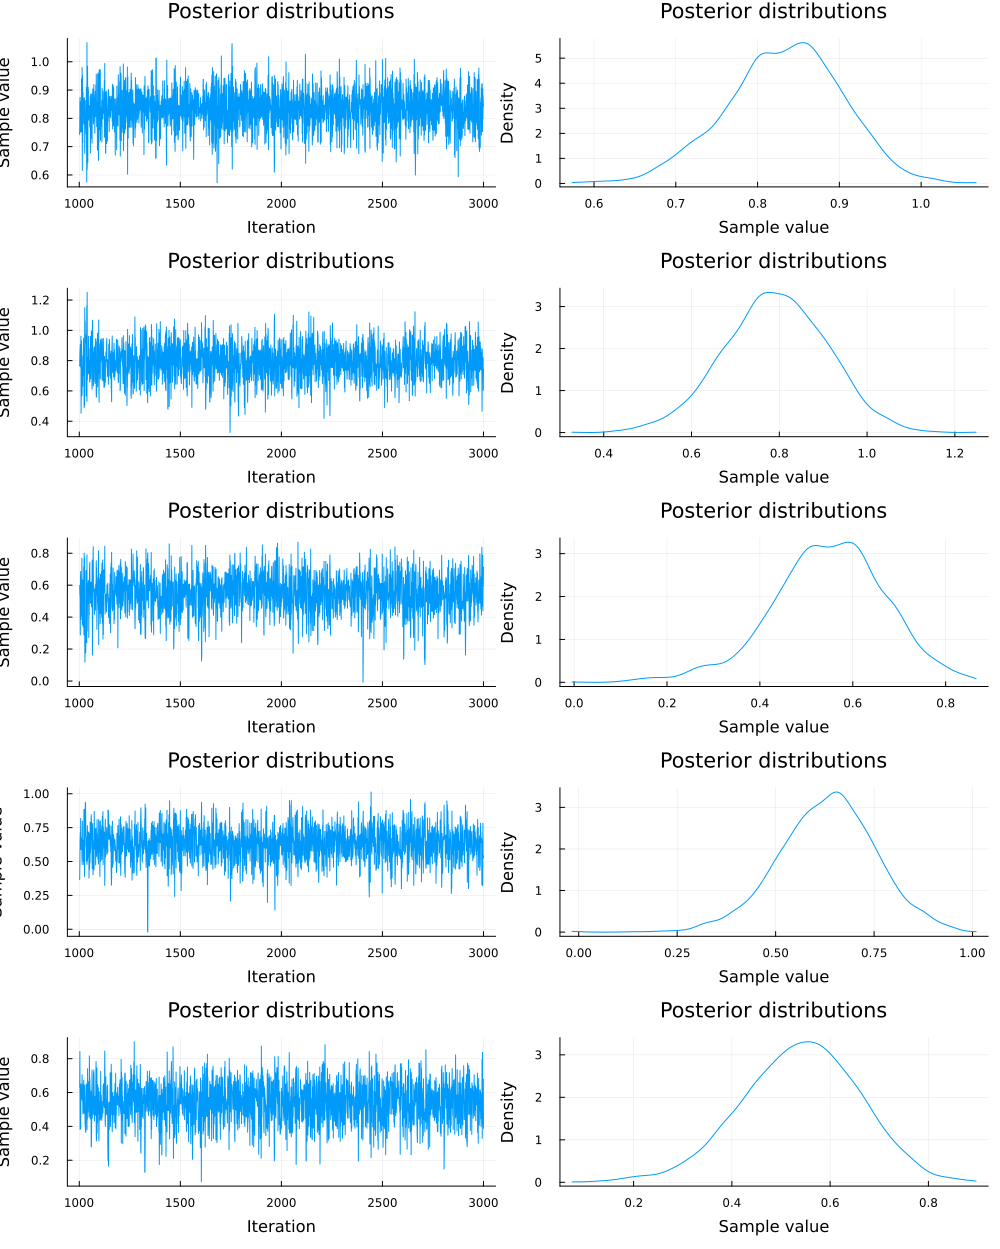

In [98]:
using StatsPlots
plot(chain[:,1:5,:], 
    vars = [:v, :l, :jitter], 
    title = "Posterior distributions", 
    label = ["v" "l" "jitter"], 
    legend = false)

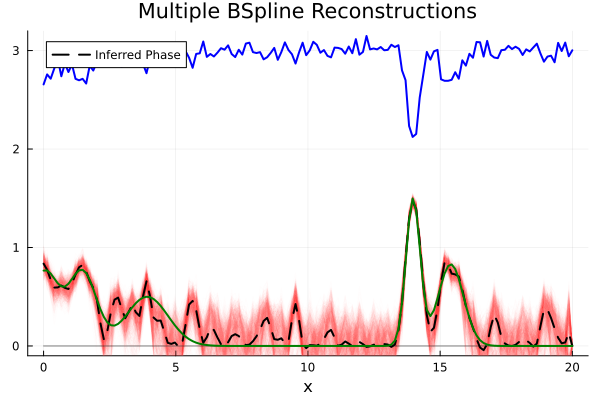

In [99]:
using Statistics, Plots, Unwrap

n_weights = length(basis)
# n_iter, n_weights = size(weights_samples)

n_basis = length(basis)  # Should be 41

# Reconstruct weights_samples as a matrix of size (iterations × n_basis)
weights_samples = reduce(hcat, [chain[Symbol("weights[$i]")] for i in 1:n_basis])
median_weights = mapslices(median, weights_samples, dims=1) |> vec

# Then build the spline
reconstructed_spline = Spline(basis, median_weights)
I_recon = (2 .+ cos.(reconstructed_spline.(x_train))) 

# I_latent = unwrap(acos.(I_recon .- 2))
# I_latent = (I_recon .- 2)

p = plot(x_train, zeros(length(x_train)),
    xlabel="x", ylabel="",
    title="Multiple BSpline Reconstructions", label="", lw=1, color=:gray)

# Plot a subset of the reconstructions to avoid clutter.
for i in 1000:1:length(chain[:,1,1])
    w = weights_samples[i, :]          # current weights sample
    spline_i = Spline(basis, w)          # build spline
    I_recon_i = (spline_i.(x_train)) # evaluate at x_train
    # I_recon_i = unwrap(acos.(clamp.(I_recon_i,-1,1)))
    plot!(p, x_train, I_recon_i, lw=1, label="", alpha=0.01, color=:red)
end
ylims!(-.1, 3.2)
plot!(x_train,reconstructed_spline.(x_train),
    label = "Inferred Phase", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash)
plot!(x_train, y_train./N_electrons, 
    label = "", 
    markersize = 2, 
    color = :blue, linewidth = 2)
# plot!(x_train, (y_latent),
#     label = "True Intensity", 
#     markersize = 2, 
#     color = :green, linewidth = 2)
plot!(x_train, y_latent,
    label = "", 
    markersize = 2, 
    color = :green, linewidth = 2)

In [ ]:
fig1 = plot(x_train[1:end-1],diff(reconstructed_spline.(x_train)),
    label = "L=1", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash);

In [82]:
fig2 = plot(x_train[1:end-1],diff(reconstructed_spline.(x_train)),
    label = "L=10", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash);

In [87]:
fig3 = plot(x_train[1:end-1],diff(reconstructed_spline.(x_train)),
    label = "L=20", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash);

In [94]:
fig4 = plot(x_train[1:end-1],diff(reconstructed_spline.(x_train)),
    label = "L=0.1", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash);

In [100]:
fig5 = plot(x_train[1:end-1],diff(reconstructed_spline.(x_train)),
    label = "L=0.1", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash);

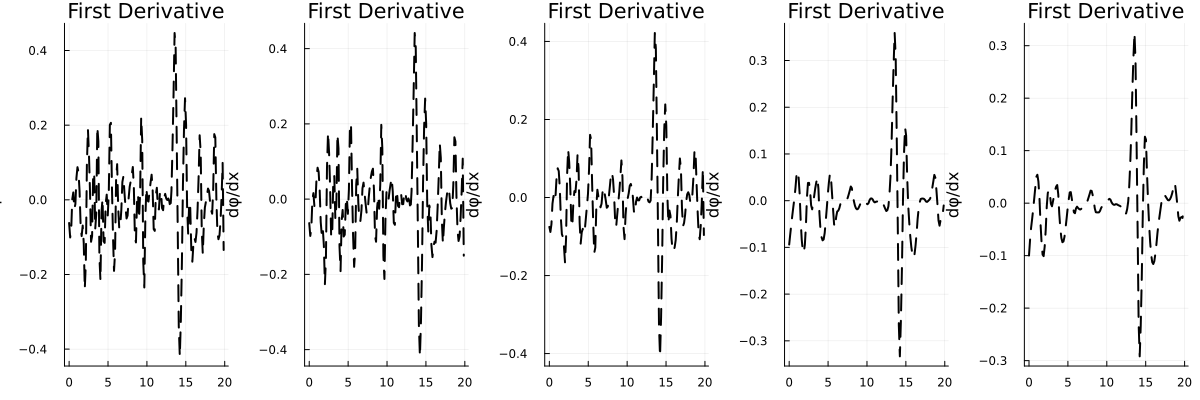

In [101]:
plot(fig5, fig4, fig1, fig2, fig3, layout = (1,5), size = (1200, 400), 
    title = "First Derivative", 
    xlabel = "x", ylabel = "dφ/dx", 
    label = "", legend = false)

In [ ]:
using Statistics, Unwrap

# μ = [mean(chain[end÷5:end, i,1]) for i in 3:42]
# σ = [std(chain[end÷5:end, i,1]) for i in 3:42]
chain_arr = chain.value  # dimensions: (iterations, parameters, chains)

# Select a subset of iterations and latent parameters (indices 3:42) from chain 1
chain_subset = chain_arr[end ÷ 5:end, 4:43, 1]

# Apply cosine elementwise on the subset
chain_trans = cos.(chain_subset)



p05 = [quantile(chain_trans[:,i,1], 0.05) for i in 1:40]
p50 = [quantile(chain_trans[:,i,1], 0.50) for i in 1:40]
p95 = [quantile(chain_trans[:,i,1], 0.95) for i in 1:40]
cos_test = 2 .+ p50
cos_upper = 2 .+ p95
plot!(x_train, abs.(unwrap(chain_subset[30,:])), label = "Inferred Phase 2", linewidth = 2, color = :black, linestyle = :dash)

cos_lower = 2 .+ p05


# println("Latent field percentiles:")
# println("Length: ", length(p16))
# println("Median size: ", size(p50))

fig1 = plot(x_train, y_train./N_electrons, label = "Intensity Data", linewidth = 2, color = :blue)
plot!(x_train, cos_test, 
    label = "Inferred Intensity", 
    title = "Inferred Intensity and Phase", 
    xlabel = "x", ylabel = "",
    markersize = 2, size=(800, 800), color=:red)
# Fill the region between y_lower and y_upper.
plot!(x_train, cos_upper, fillrange = cos_lower, fillalpha = 0.3,
      fillcolor = :gray, linecolor = :transparent, label = "")

# Optionally, plot the boundaries and latent field.
plot!(x_train, cos_lower, label = "", linestyle = :dash, color = :red)
plot!(x_train, cos_upper, label = "", linestyle = :dash, color = :red)






plot!(x_train, y_latent, label = "latent phase", linewidth = 2, color = :green)
p50 = [quantile(chain[end÷5:end, i, 1], 0.50) for i in 4:43]

plot!(x_train, abs.(unwrap(p50)), label = "Inferred Phase", linewidth = 2, color = :black, linestyle = :dash)
display(fig1)


BoundsError: BoundsError: attempt to access 2000×24×1 Array{Float64, 3} at index [400:2000, 4:43, 1]

In [8]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511.0 #keV
    return hc/sqrt(abs(E*(2*E₀ + E)))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((abs(Cs)*Wavelength(E)^3)))^(1/4)
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms
λ_const = Wavelength(E)

N = 2^5
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2
disk = Float64.(disk)

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)
gauss(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )

gauss (generic function with 1 method)

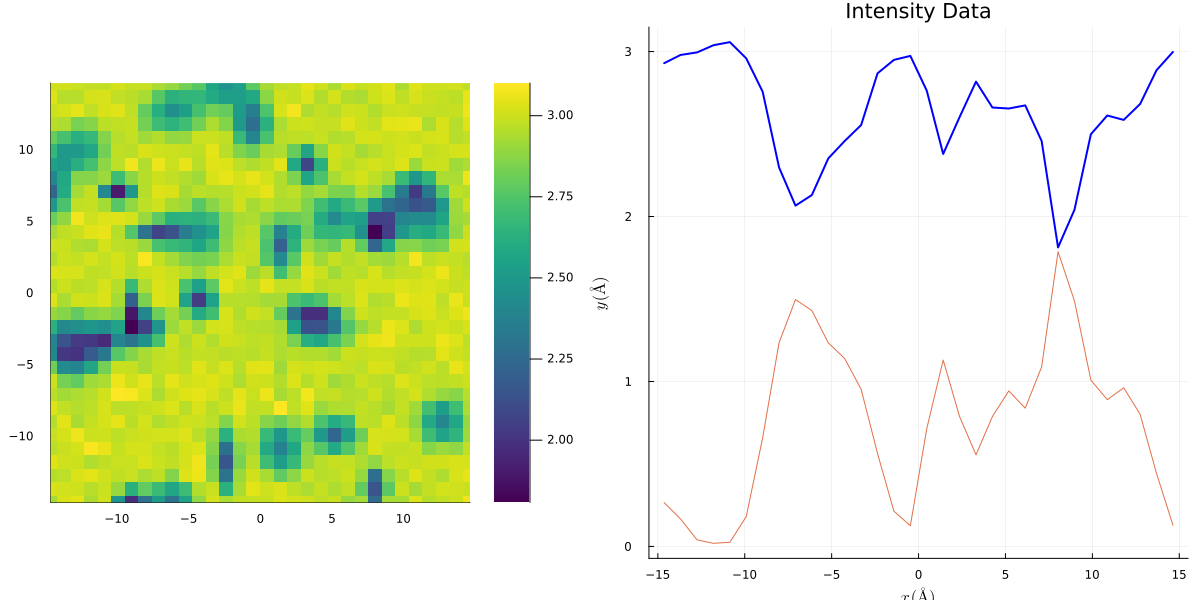

In [9]:
phase = zeros(N, N)


θ_rot = deg2rad(0)
rotatedx = @. cos(θ_rot)*x' + sin(θ_rot)*y
rotatedy = @. -sin(θ_rot)*x' + cos(θ_rot)*y
Random.seed!(1)
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
for i in 1:30
    xc = rand(x)
    yc = rand(y)
    σx, σy = rand(Uniform(0.5, 1.5)), rand(Uniform(0.5, 1.5))
    phase += gauss(rotatedx,rotatedy, xc, yc, σx, σy)

end
N_electrons = 50
ϵ = 0.01
phase = log.(5*phase./maximum(phase) .+ 1)
phase = phase .+ ϵ*randn(N,N)
Intensity = (2 .+ cos.(phase))*N_electrons^2
y_train = rand.(Poisson.(Intensity))


fig1 = heatmap(x,y,y_train./N_electrons^2, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
# xlabel!(L"x\, (Å)")
# ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
shift = 5
fig2 = plot(x, y_train[N÷2+shift,:]./N_electrons^2, 
    label = "Intensity Data", 
    title = "Intensity Data", 
    xlabel = L"x\, (Å)", ylabel = L"y\, (Å)",
    markersize = 2, size=(800, 800), color=:blue, linewidth = 2)
    plot!(x, phase[N÷2 + shift,:])
plot(fig1, fig2, layout = (1, 2), size = (1200, 600), legend = false)
# title!("angle of tramission function \n (π Gaussians)")

In [10]:
X, Y = meshgrid(x,y)
inputs = Matrix{eltype(x)}(undef,2, length(y)*length(x))
inputs[1,:] = vec(X)
inputs[2,:] = vec(Y)
Intensity_vec = vec(y_train)



@model function latent_model_2(y, x_inputs = inputs, N_poisson=N_electrons)
    v ~ Gamma(2, 1)
    l ~ Gamma(4, 1)
    jitter ~ Uniform(0, 0.04)
    
    fx = GP(v * with_lengthscale(SEKernel(), l))
    # f_latent ~ truncated(f(x_input, jitter), -0.2, π/2 + 0.2)
    f_latent ~ fx(x_inputs, jitter)
    local I = (2 .+ cos.(f_latent)).* N_poisson^2
    y ~ arraydist(Poisson.(I))
end

model_2 = latent_model_2(Intensity_vec)
# sampler = Turing.NUTS(10,0.65, max_depth=6; adtype=AutoReverseDiff(compile=true))
sampler = Turing.SGLD(adtype=AutoReverseDiff(compile=true))
# sampler = Turing.MH()



chain = sample(model_2, sampler, 20; progress=true)

Sampling   0%|                                          |  ETA: N/A
Sampling   5%|██▏                                       |  ETA: 0:05:25
Sampling  10%|████▎                                     |  ETA: 0:02:52
Sampling  15%|██████▎                                   |  ETA: 0:01:58
Sampling  20%|████████▍                                 |  ETA: 0:01:40
Sampling  25%|██████████▌                               |  ETA: 0:01:28
Sampling  30%|████████████▋                             |  ETA: 0:01:19
Sampling  35%|██████████████▊                           |  ETA: 0:01:11
Sampling  40%|████████████████▊                         |  ETA: 0:01:06
Sampling  45%|██████████████████▉                       |  ETA: 0:00:59
Sampling  50%|█████████████████████                     |  ETA: 0:00:53
Sampling  55%|███████████████████████▏                  |  ETA: 0:00:47
Sampling  60%|█████████████████████████▎                |  ETA: 0:00:41
Sampling  65%|███████████████████████████▎              |  ETA: 0:00

Chains MCMC chain (20×1029×1 Array{Float64, 3}):

Iterations        = 1:1:20
Number of chains  = 1
Samples per chain = 20
Wall duration     = 96.57 seconds
Compute duration  = 96.57 seconds
parameters        = v, l, jitter, f_latent[1], f_latent[2], f_latent[3], f_latent[4], f_latent[5], f_latent[6], f_latent[7], f_latent[8], f_latent[9], f_latent[10], f_latent[11], f_latent[12], f_latent[13], f_latent[14], f_latent[15], f_latent[16], f_latent[17], f_latent[18], f_latent[19], f_latent[20], f_latent[21], f_latent[22], f_latent[23], f_latent[24], f_latent[25], f_latent[26], f_latent[27], f_latent[28], f_latent[29], f_latent[30], f_latent[31], f_latent[32], f_latent[33], f_latent[34], f_latent[35], f_latent[36], f_latent[37], f_latent[38], f_latent[39], f_latent[40], f_latent[41], f_latent[42], f_latent[43], f_latent[44], f_latent[45], f_latent[46], f_latent[47], f_latent[48], f_latent[49], f_latent[50], f_latent[51], f_latent[52], f_latent[53], f_latent[54], f_latent[55], f_latent[56], f

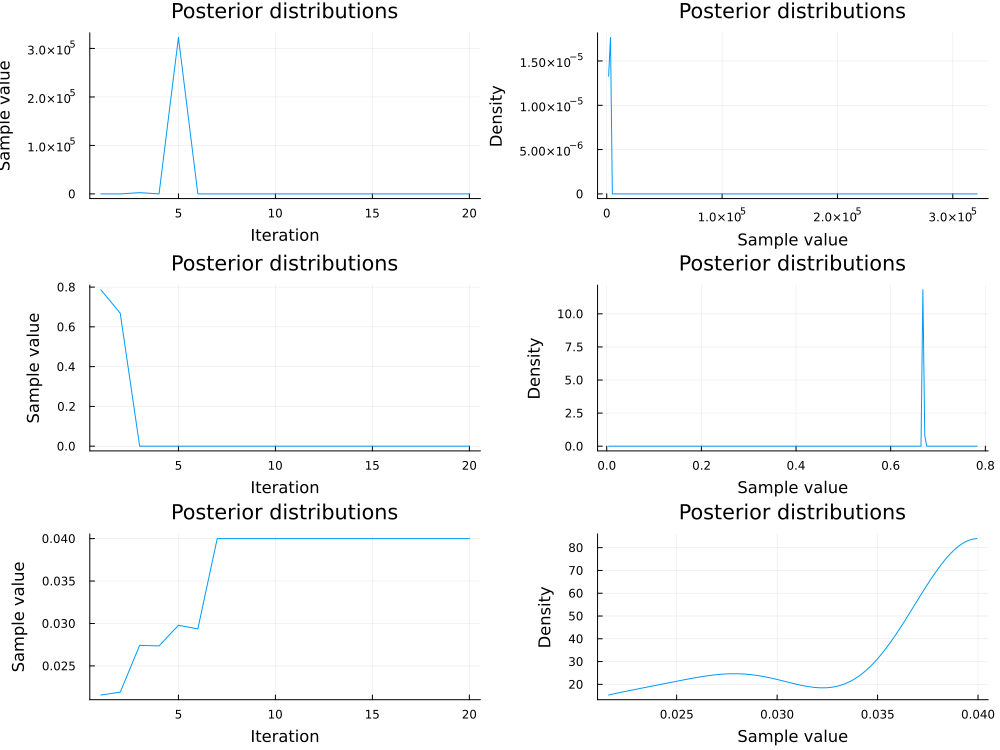

In [11]:
plot(chain[:,1:3,:], 
    vars = [:v, :l, :jitter], 
    title = "Posterior distributions", 
    label = ["v" "l" "jitter"], 
    legend = false)

In [12]:
fx = f(inputs, 1e-3)
f_posterior = posterior(fx,y_2_fit)
outputs = f_posterior(inputs)
mean_vals = mean(outputs)
println(size(outputs))
println(size(mean_vals))
outputs = reshape(outputs, length(y), length(x))
mean_vals = reshape(mean_vals, length(y), length(x))
fig1 = heatmap(mean_vals)
fig2 = heatmap(phase)
plot(fig1, fig2, layout=(1,2), size=(800,500))

UndefVarError: UndefVarError: `f` not defined in `Main`
Suggestion: check for spelling errors or missing imports.